In [9]:
!pip install category_encoders==2.*
!pip install eli5
!pip install xgboost

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [11]:
train = pd.read_csv('Video_games_esrb_rating.csv')
test = pd.read_csv('test_esrb.csv')

In [12]:
def wrangle(df):
    df = df.rename(columns={'strong_janguage':'strong_language'})
    return df

In [13]:
df = wrangle(train)
X_test = wrangle(test)

In [14]:
df.head()

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     1895 non-null   object
 1   console                   1895 non-null   int64 
 2   alcohol_reference         1895 non-null   int64 
 3   animated_blood            1895 non-null   int64 
 4   blood                     1895 non-null   int64 
 5   blood_and_gore            1895 non-null   int64 
 6   cartoon_violence          1895 non-null   int64 
 7   crude_humor               1895 non-null   int64 
 8   drug_reference            1895 non-null   int64 
 9   fantasy_violence          1895 non-null   int64 
 10  intense_violence          1895 non-null   int64 
 11  language                  1895 non-null   int64 
 12  lyrics                    1895 non-null   int64 
 13  mature_humor              1895 non-null   int64 
 14  mild_blood              

In [16]:
#Split Data
target = 'esrb_rating'
y = df[target]
X = df.drop(columns=target)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
#Baseline
print("Baseline Accuracy:", y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.358179419525066


In [19]:
#Build Model
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, max_depth=21, n_estimators=150, max_leaf_nodes=1550, min_samples_leaf=2, min_samples_split=3))

model_rf.fit(X_train, y_train);

In [20]:
model_skgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42)
)

model_skgb.fit(X_train, y_train);

In [21]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=-1))

model_xgb.fit(X_train, y_train);

[17:39:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
#Check Metrics
print('sklearn Training Accuracy:', model_rf.score(X_train, y_train))
print('sklearn Validation Accuracy:', model_rf.score(X_val, y_val))

sklearn Training Accuracy: 0.9030343007915568
sklearn Validation Accuracy: 0.8337730870712401


In [23]:
print('sklearn Training Accuracy:', model_skgb.score(X_train, y_train))
print('sklearn Validation Accuracy:', model_skgb.score(X_val, y_val))

sklearn Training Accuracy: 0.9023746701846965
sklearn Validation Accuracy: 0.8100263852242744


In [24]:
print('XGBoost Training Accuracy:', model_xgb.score(X_train, y_train))
print('XGBoost Validation Accuracy:', model_xgb.score(X_val, y_val))

XGBoost Training Accuracy: 0.9920844327176781
XGBoost Validation Accuracy: 0.8311345646437994


In [25]:
#Tune Model
param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(10, 25, 1),
    'randomforestclassifier__n_estimators': [150],
    'randomforestclassifier__max_leaf_nodes': range(750, 2000, 50)
}

model = RandomizedSearchCV(
    model_rf,
    param_distributions=param_grid,
    n_iter=25,
    cv=10,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train);

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [26]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.8450026141512721
Best params for `model`: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_leaf_nodes': 1300, 'randomforestclassifier__max_depth': 21}


In [27]:
#Permutation Importance
perm_imp = permutation_importance(model_rf, 
                                  X_val, 
                                  y_val, 
                                  n_repeats=5, 
                                  n_jobs=-1, 
                                  random_state=42)

In [28]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean')

importances.head()

,imp_mean,imp_std
crude_humor,-0.002111,0.004539
nudity,-0.000528,0.001055
alcohol_reference,-0.000528,0.001974
mild_language,0.000000,0.000000
use_of_drugs_and_alcohol,0.000000,0.000000


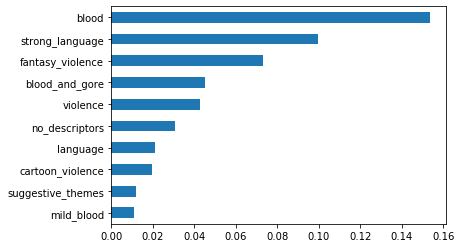

In [29]:
importances['imp_mean'].tail(10).plot(kind='barh')
plt.show()

In [30]:
X_val.head()

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
1319,Inksplosion,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
611,Citadel: Forged with Fire,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
964,Astérix & Obélix XXL 2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1316,CoolpaintrVR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
585,Ghostbusters: The Video Game Remastered,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


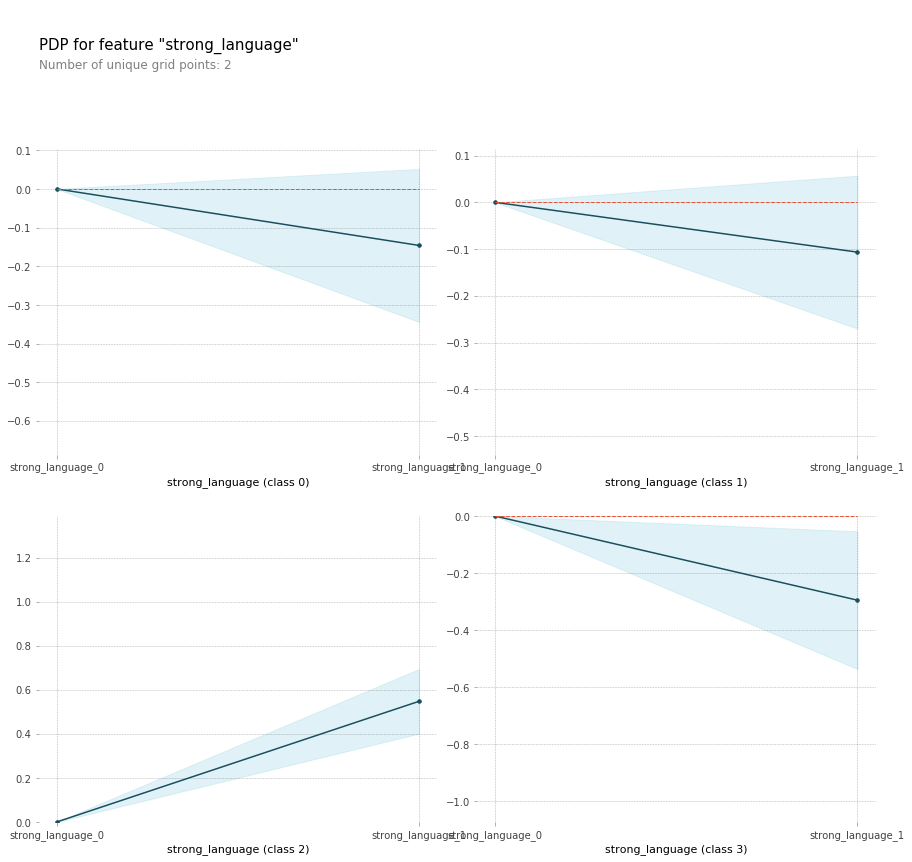

In [31]:
feature = 'strong_language'

isolate = pdp_isolate(
    model_rf,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


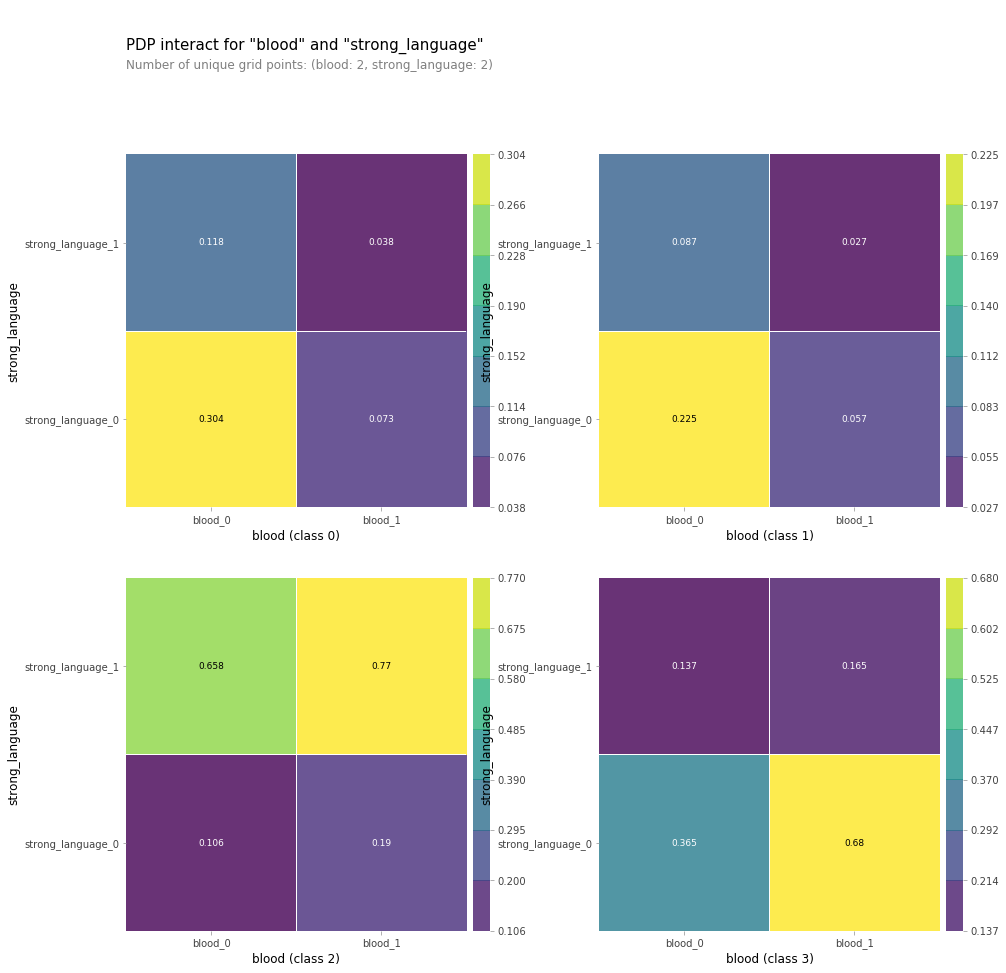

In [32]:
features = ['blood', 'strong_language']

interact = pdp_interact(
    model_rf,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [34]:
X_train.head(5)

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
339,GALAK-Z: The Void,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1386,Time Carnage,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
544,Lichtspeer: Double Speer Edition,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
937,Air Missions: HIND,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
741,DreamWorks Dragons Dawn of New Riders,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df.head(5)

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T
